# Historical warming

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
import datetime as dt
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scmdata
import scmdata.database
import seaborn as sns

import utils
import utils.plotting
import utils.scmdata

<IPython.core.display.Javascript object>

/data/ubuntu-znicholls/miniconda3/envs/nicholls-et-al-2022-emulator-changes/lib/python3.7/site-packages/scmdata/database.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


<IPython.core.display.Javascript object>

In [4]:
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["axes.xmargin"] = 0
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams["text.usetex"] = False
plt.rcParams["axes.unicode_minus"] = False

<IPython.core.display.Javascript object>

In [5]:
model_output = []
for label, directory in (
    (
        "AR6 calibration SR1.5 processing",
        os.path.join("ar6-output", "MAGICC", utils.AR6_OUTPUT_SR15_RAW_ID),
    ),
    (
        "AR6 calibration SR1.5 processing",
        os.path.join("ar6-output", "fair", "sr15-processing"),
    ),
    (
        "RCMIP Phase 2 calibration SR1.5 processing",
        os.path.join(
            "ar6-output", "MAGICC", utils.AR6_OUTPUT_SR15_RAW_RCMIP_PHASE_2_CONFIG_ID
        ),
    ),
    (
        "SR1.5 calibration SR1.5 processing",
        os.path.join("sr15-output"),
    ),
):
    db = scmdata.database.ScmDatabase(
        os.path.join(
            utils.DATA_DIR,
            "processed",
            directory,
        ),
        levels=("variable", "percentile"),
    )

    tmp = db.load(variable="Surface Temperature (GSAT)")
    tmp["id"] = f"{label} " + tmp["climate_model"]
    model_output.append(tmp)

model_output = scmdata.run_append(model_output)
model_output

Loading files:   0%|          | 0/9 [00:00<?, ?it/s]

Loading files:   0%|          | 0/9 [00:00<?, ?it/s]

Loading files:   0%|          | 0/9 [00:00<?, ?it/s]

Loading files:   0%|          | 0/5 [00:00<?, ?it/s]

<scmdata.ScmRun (timeseries: 15202, timepoints: 106)>
Time:
	Start: 1995-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	      Kyoto-GHG|2010 (SAR) SR1.5 Table 2.4 aim_over_sampling climate_model  \
	0                      NaN             NaN               NaN  MAGICCv7.5.3   
	1                      NaN             NaN               NaN  MAGICCv7.5.3   
	2                      NaN             NaN               NaN  MAGICCv7.5.3   
	3                      NaN             NaN               NaN  MAGICCv7.5.3   
	4                      NaN             NaN               NaN  MAGICCv7.5.3   
	...                    ...             ...               ...           ...   
	15197             in range           False              True       MAGICC6   
	15198             in range           False              True       FaIR1.3   
	15199             in range           False              True       MAGICC6   
	15200             in range           False              True       FaIR1.3   
	15201     

<IPython.core.display.Javascript object>

In [6]:
obs_db = scmdata.database.ScmDatabase(
    os.path.join(utils.DATA_DIR, "processed", "observations", utils.OBS_DB_ID),
    levels=("variable", "percentile"),
)

<IPython.core.display.Javascript object>

In [7]:
obs = obs_db.load(variable="Surface Temperature (GSAT)").relative_to_ref_period_mean(
    year=range(1850, 1900 + 1)
)
obs

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

<scmdata.ScmRun (timeseries: 2, timepoints: 173)>
Time:
	Start: 1850-01-01T00:00:00
	End: 2022-01-01T00:00:00
Meta:
	             model percentile  reference_period_end_year  \
	0  HadCRUT.4.6.0.0       50.0                       1900   
	1  HadCRUT.5.0.1.0       50.0                       1900   
	
	   reference_period_start_year region    scenario unit  \
	0                         1850  World  historical    K   
	1                         1850  World  historical    K   
	
	                     variable  
	0  Surface Temperature (GSAT)  
	1  Surface Temperature (GSAT)  

<IPython.core.display.Javascript object>

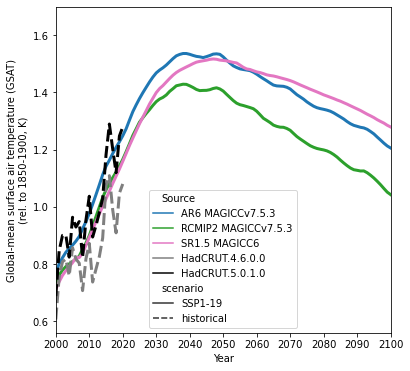

<IPython.core.display.Javascript object>

In [8]:
obs_pdf = obs.copy()
obs_pdf["id"] = obs_pdf["model"]
pdf = (
    model_output.filter(id="*MAGICC*")
    .append(obs_pdf.filter(year=range(1, 2020 + 1)))
    .filter(
        scenario=[
            "historical",
            #             "SSP1-26",
            "SSP1-19",
        ],
        model=["HadCRUT*", "IMAGE*"],
        #     scenario=[
        #         "historical",
        #         "SSP2-45",
        #     ],
        #     model=["HadCRUT*", "MESSAGE*"],
        percentile="50.0",
    )
)

fig, ax = plt.subplots(figsize=(6, 6))

pdf["Source"] = pdf["id"].map(
    lambda x: utils.plotting.ID_MAP[x] if x in utils.plotting.ID_MAP else x
)
ax = (
    pdf.filter(
        year=range(2000, 2100 + 1),
    )
    #     .relative_to_ref_period_mean(year=2020)
    .lineplot(
        hue="Source",
        palette={
            **{
                utils.plotting.ID_MAP[k]: v
                for k, v in utils.plotting.ID_COLOURS.items()
            },
            "HadCRUT.5.0.1.0": "black",
            "HadCRUT.4.6.0.0": "tab:gray",
        },
        style="scenario",
        linewidth=3,
    )
)

# ax.grid()
# ax.set_yticks(np.arange(0.5, 1.91, 0.1))
ax.grid(which="minor")
ax.set_xlabel("Year")
ax.set_ylabel("Global-mean surface air temperature (GSAT)\n(rel. to 1850-1900, K)")
ax.set_ylim(ymax=1.7)
plt.savefig(
    os.path.join(utils.FIGURES_DIR, f"109_magicc-calib-differences.pdf"),
    transparent=True,
)
plt.show()

id percentile            model    scenario  value
0  HadCRUT.4.6.0.0       50.0  HadCRUT.4.6.0.0  historical   0.80
1  HadCRUT.5.0.1.0       50.0  HadCRUT.5.0.1.0  historical   0.92
2              AR6       50.0             IPCC  historical   0.90
3              AR5       50.0             IPCC  historical   0.78

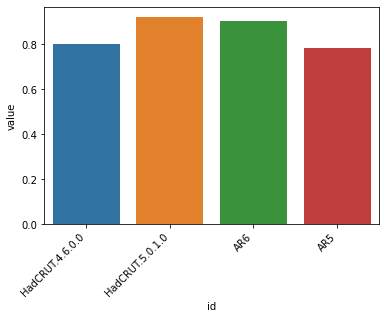

id percentile            model    scenario  value
0  HadCRUT.4.6.0.0       50.0  HadCRUT.4.6.0.0  historical   0.76
1  HadCRUT.5.0.1.0       50.0  HadCRUT.5.0.1.0  historical   0.87
2              AR6       50.0             IPCC  historical   0.85

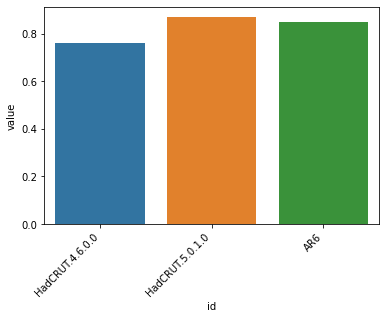

id percentile            model    scenario  value
0  HadCRUT.4.6.0.0       50.0  HadCRUT.4.6.0.0  historical   0.83
1  HadCRUT.5.0.1.0       50.0  HadCRUT.5.0.1.0  historical   0.97
2              AR6       50.0             IPCC  historical   0.94
3        SR1.5 RCB       50.0             IPCC  historical   0.97

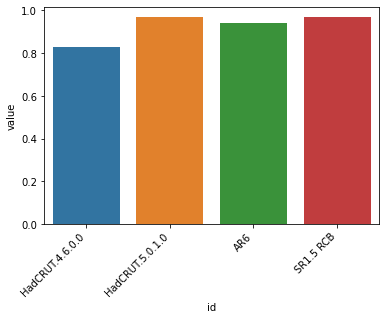

<IPython.core.display.Javascript object>

In [9]:
for year_range, ipcc_dat in (
    (range(2003, 2012 + 1), (("AR6", 0.9), ("AR5", 0.78))),
    (range(1995, 2014 + 1), (("AR6", 0.85),)),
    (range(2006, 2015 + 1), (("AR6", 0.94), ("SR1.5 RCB", 0.97))),
):
    tmp = (
        pdf.filter(year=year_range, scenario=["SSP1-26", "historical"])
        .filter(id="SR1.5 FaIR1.3", keep=False)  # data doesn't start until 2010
        .timeseries(meta=["id", "percentile", "model", "scenario"])
        .mean(axis=1)
        .round(2)
        .to_frame("value")
        .reset_index()
    )
    for label, val in ipcc_dat:
        tmp = tmp.append(
            {
                "id": label,
                "percentile": 50.0,
                "model": "IPCC",
                "scenario": "historical",
                "value": val,
            },
            ignore_index=True,
        )

    display(tmp)
    ax = sns.barplot(data=tmp, y="value", x="id")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
    plt.show()